# Laboratorio 5: Análisis de sentimientos
- José Block
- Francisco Rosal
- Gian Luca Rivera

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
%matplotlib inline

Importamos rpy2 para que el código realizado con R pueda, tambien, ser utilizado con sintaxis python.

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
knitr::opts_chunk$set(echo = TRUE)

In [9]:
%%R
library(readr)
if (!require("tm"))    {install.packages("tm");   library("tm")}
if (!require("dplyr"))    {install.packages("dplyr");   library("dplyr")}
if (!require("tidytext"))    {install.packages("tidytext");   library("tidytext")}
if (!require("plotly"))    {install.packages("plotly");   library("plotly")}
if (!require("stringr"))    {install.packages("stringr");   library("stringr")}
if (!require("xml2"))    {install.packages("xml2");   library("xml2")}
if (!require("SnowballC"))    {install.packages("SnowballC");   library("SnowballC")}
if (!require("wordcloud"))    {install.packages("wordcloud");   library("wordcloud")}
if (!require("wordcloud2"))    {install.packages("wordcloud2");   library("wordcloud2")}
if (!require("RColorBrewer"))    {install.packages("RColorBrewer");   library("RColorBrewer")}
if (!require("stylo"))    {install.packages("stylo");   library("stylo")}
if (!require("SentimentAnalysis"))    {install.packages("SentimentAnalysis");   library("SentimentAnalysis")}

# Lectura de datos

In [10]:
%%R 
GrammarandProductReviews <- read_csv("./GrammarandProductReviews.csv")

Rows: 71044 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): id, brand, categories, keys, manufacturer, manufacturerNumber, na...
dbl   (3): reviews.id, reviews.numHelpful, reviews.rating
lgl   (2): reviews.didPurchase, reviews.doRecommend
dttm  (3): dateAdded, dateUpdated, reviews.dateAdded

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Realizamos un conteo de NA de cada una de las columnas, las columnas que no necesitamos, las eliminamos.

In [11]:
%%R
sapply(GrammarandProductReviews, function(x) sum(is.na(x)))

                  id                brand           categories 
                   0                    0                    0 
           dateAdded          dateUpdated                  ean 
                   0                    0                31979 
                keys         manufacturer   manufacturerNumber 
                   0                    0                  203 
                name         reviews.date    reviews.dateAdded 
                   0                   67                    0 
    reviews.dateSeen  reviews.didPurchase  reviews.doRecommend 
                   0                38886                10615 
          reviews.id   reviews.numHelpful       reviews.rating 
               38886                38536                    0 
  reviews.sourceURLs         reviews.text        reviews.title 
                   0                   34                  475 
    reviews.userCity reviews.userProvince     reviews.username 
               65634                7059

Se eliminarán las columnas:

- id: por cadencia de información.

- reviews.userProvince: por alta cantidad de NA.

- review.userCity: por alta cantidad de NA.

- reviews.id: por cadencia de información y cantidad de NA.

- reviews.numHelpful:por cadencia de información y cantidad de NA.

- keys: por cadencia de información.

- dates, no se hará nada con fechas.

In [12]:
%%R
df <- subset(GrammarandProductReviews, select = -c(1, 4, 5, 6, 7, 11, 12, 13, 16, 17, 19, 22, 23))

# Limpieza y preprocesación de datos

Realizamos las siguientes acciones para limpiar y preprocesar el dataset: convertir todo a minusculas, eliminar caracteres especiales, eliminamos URL, eliminamos emojis, eliminamos signos de puntuación, eliminamos stopwords y eliminamos los numeros ya que no nos dan información relevante.

In [13]:
%%R
colnames(df)
df$reviews.text  <- str_replace_all(df$reviews.text, "[[:punct:]]", " ")
df$reviews.title <- str_replace_all(df$reviews.title, "[[:punct:]]", " ")
df$reviews.text  <- tolower(df$reviews.text)
df$reviews.title <- tolower(df$reviews.title)
df$reviews.text <- gsub('\\p{So}|\\p{Cn}', '', df$reviews.text, perl = TRUE)
df$reviews.title <- gsub('\\p{So}|\\p{Cn}', '', df$reviews.title, perl = TRUE)
df$reviews.text <- gsub('[0-9]+', '', df$reviews.text, perl = TRUE)
df$reviews.title <- gsub('[0-9]+', '', df$reviews.title, perl = TRUE)

stopwords_regex = paste(stopwords('en'), collapse = '\\b|\\b')
stopwords_regex = paste0('\\b', stopwords_regex, '\\b')
df$reviews.text = stringr::str_replace_all(df$reviews.text, stopwords_regex, '')
head(df$reviews.title)
df$reviews.title = stringr::str_replace_all(df$reviews.title, stopwords_regex, '')
head(df$reviews.text)

[1] " love  album   s  good     hip hop side   current pop sound    hype   listen   everyday   gym   give  star rating   way   metaphors  just crazy "                                                                                                                                                                                                                                                                                                                                                                       
[2] "good flavor   review  collected  part   promotion "                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Análisis Exploratorio

Obtenemos las palabras que más se repiten en las review.

In [14]:
%%R
dfsplit <- strsplit(df$reviews.text, "\\W")
dfunlist <- unlist(dfsplit)
freq <-table(dfunlist)
freq<-sort(freq, decreasing=TRUE)
head(freq, n = 20)

dfunlist
              great   product     movie    review      part promotion collected 
  1671020     21142     20464     20002     18929     18671     17734     17726 
     love         t       use      good      like         s      skin       one 
    17010     16425     16080     12328     11409     11262     10737     10335 
     hair    really      just      will 
     8999      8620      8493      8202 


In [15]:
reviews = %R dfunlist
frequency = Counter(reviews)
common = frequency.most_common(11)
common.pop(0)
common

[('great', 21142),
 ('product', 20464),
 ('movie', 20002),
 ('review', 18929),
 ('part', 18671),
 ('promotion', 17734),
 ('collected', 17726),
 ('love', 17010),
 ('t', 16425),
 ('use', 16080)]

Realizamos una nube de palabras para visualizar las palabras que mas se repiten en las reviews.

In [16]:
%%R
wordcloud2(data=freq, size=32, color='random-dark')

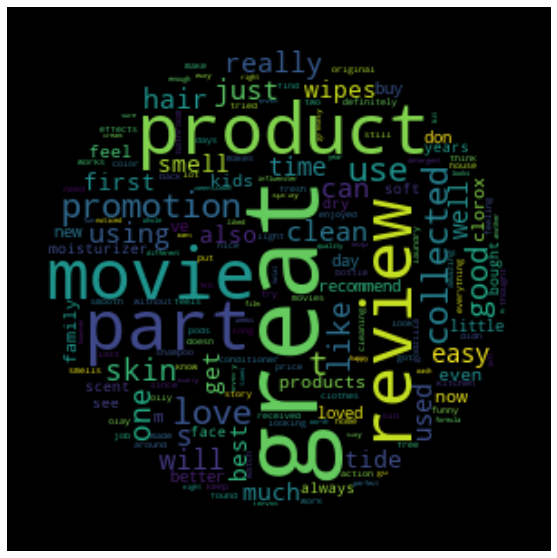

In [17]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(WordCloud(mask=mask).generate_from_frequencies(frequency), interpolation="bilinear")

Tambien realizamos un histograma para ver la proporcion de las palabras que más se repiten en las reviews.

In [18]:
%%R
freq = freq[-1]
frequ <- head(freq)
plot_ly(x = ~names(frequ),y = as.numeric(frequ), type = "bar")

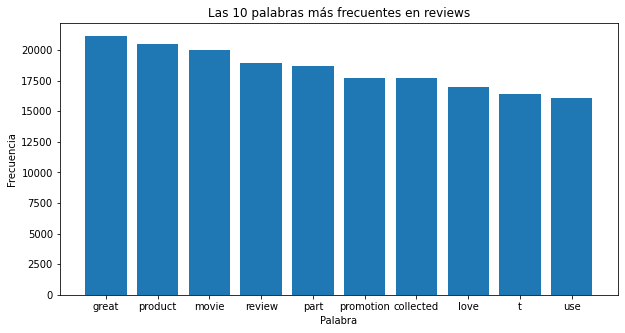

In [19]:
words = [word for word, _ in common]
counts = [counts for _, counts in common]

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.title("Las 10 palabras más frecuentes en reviews")
plt.ylabel("Frecuencia")
plt.xlabel("Palabra")
plt.show()

Se notó que las palabras que mas se repiten en los reviews hacen referencia al producto y a que hay una tendencia a que sea bueno el producto. Se nota tambien cómo han servido las promociones que han hecho, ya que hablan mucho de ello. Es decir, las palabras que mas se repiten en las reviews tienden a ser palabras que utilizamos para decir que es un buen producto o bien a un producto en especifico como "movie".

Determinamos las palabras entre positivas y negativas

In [20]:
%%R
prince_tidy <- df %>%
  unnest_tokens(word, reviews.text) %>%
  anti_join(stop_words)

Joining, by = "word"


In [21]:
%%R
bing_word_counts <- prince_tidy %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()
bing_word_counts

Joining, by = "word"
# A tibble: 2,932 × 3
   word      sentiment     n
   <chr>     <chr>     <int>
 1 love      positive  17010
 2 clean     positive   7910
 3 easy      positive   5824
 4 smell     negative   5279
 5 recommend positive   4296
 6 loved     positive   3990
 7 soft      positive   3588
 8 free      positive   3349
 9 nice      positive   3275
10 funny     negative   2762
# … with 2,922 more rows


# Análisis de sentimientos

Primero igualamos todo lo realizado en R a una variable python para que este analisis se realice precisamente en python.

In [141]:
data = %R df

Realizamos una funcion para determinar a que sentimiento pertenece cada palabra ya que la libreria de TextBlob nos devuelve un numero y segun el rango de ese numero es un sentimiento positivo, negativo o neutral.

In [142]:
def sentiment(word): 
    if TextBlob(word).sentiment.polarity > 0: 
        return 'positive'
    elif TextBlob(word).sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

Realizamos un ultimo preprocesamiento al dataset para que pueda ser utilizado con python, eliminamos las letras sueltas, es decir aquellas letras que no estan unidas a una palabra (e.j "l", "s") y quitamos espacios en blanco dobles.

In [143]:
text_reviews = []
for i in range(len(data['reviews.text'])):
  if data['reviews.text'].iloc[i] != None:
    r = ' '.join( [w for w in data['reviews.text'].iloc[i].split() if len(w)>1])
    text_reviews.append(r)
  else:
    text_reviews.append("none")

Recorremos la columna de review y analizamos el sentimiento de cada palabra

In [144]:
sentiment_ = pd.Series(text_reviews).apply(lambda x: sentiment(x))

Graficamos los sentimientos que obtuvimos para observar cual es el sentimiento que predomina en los reviews de productos.

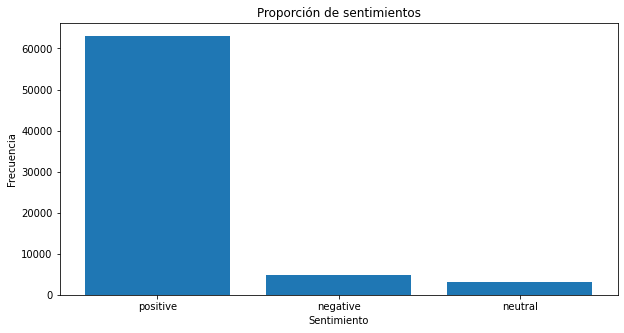

In [164]:
counter = sentiment_.value_counts()
plt.figure(figsize=(10,5))
plt.bar(counter.index, counter.values)
plt.title("Proporción de sentimientos")
plt.ylabel("Frecuencia")
plt.xlabel("Sentimiento")
plt.show()

Agregamos la columna de sentimiento al dataset para que la podamos utilizar en el filtro de los siguientes ejercicios.

In [145]:
data.insert(len(data.columns), "sentiment", sentiment_.values, True)

In [146]:
data[['reviews.text', 'sentiment']]

,reviews.text,sentiment
1,love album s good hip hop side curr...,positive
2,good flavor review collected part promot...,positive
3,good flavor,positive
4,read reviews looking buying one coup...,negative
5,husband bought gel us gel caused irritati...,neutral
...,...,...
71040,m dealing dry eyes sensitive products e...,negative
71041,great stuff helps keep contacts moist day,positive
71042,right price,positive
71043,pleased scarf arrived multiple reasons ...,positive


# Los 10 productos de mejor calidad dado su review

Para saber cuales son los productos de mejor calidad dado su review, obtenemos aquellos productos que tengan una puntuacion de 5 puntos, que el usuario que realizo el review haya comprado ese producto y que el sentimiento del review sea positivo.

In [147]:
pmejor = data[(data['reviews.rating'] == 5) & (data['sentiment'] == 'positive')]
countp = pmejor['name'].value_counts()
_ = [print('-', i) for i in countp[:10].index]


- Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
- The Secret Life Of Pets (4k/uhd + Blu-Ray + Digital)
- Tide Original Liquid Laundry Detergent - 100 Oz
- The Jungle Book (blu-Ray/dvd + Digital)
- Clorox Disinfecting Bathroom Cleaner
- Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd
- L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
- L'oreal Paris Revitalift Triple Power Deep-Acting Moisturizer
- Independence Day Resurgence (4k/uhd + Blu-Ray + Digital)
- Tide Pods Detergent, Botanical Rain, 61ct


# Los 10 productos de menor calidad dado su review

Para obtener los de menor calidad, realizamos el mismo procedimiento que antes unicamente que tenga un sentimiento negativo.

In [148]:
pmenor = data[(data['reviews.rating'] == 1) & (data['sentiment'] == 'negative')]
countm = pmenor['name'].value_counts()
_ = [print('-', i) for i in countm[:10].index]

- Nexxus Exxtra Gel Style Creation Sculptor
- Rubbermaid174 Reveal Spray Mop
- Tide Original Liquid Laundry Detergent - 100 Oz
- Maybelline Eye Studio Master Duo Glossy Liquid Liner, Black Lacquer
- Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz
- Independence Day Resurgence (4k/uhd + Blu-Ray + Digital)
- Clear Scalp & Hair Therapy Total Care Nourishing Shampoo
- Olay Total Effects Daily Moisturizer, 7-In-1 Anti-Aging, 0.5oz
- Sausage Party (4k/uhd + Digital)
- Maybelline Instant Age Rewind Eraser Dark Circles Treatment Concealer, Fair


# Usuarios que dan mayor cantidad de reviews a distintos productos

Para esta unicamente necesitamos realizar un conteo del usuario que mas reviews tiene

In [154]:
muser = names['reviews.username'].value_counts()
_ = [print('-', i) for i in muser[:10].index]

- Donna
- An anonymous customer
- WindowKitty
- Sandy
- Erica
- kevman79
- Grace
- Susan
- Unhappy
- Nolaluv


# Usuarios que dan más reviews negativos

Filtramos por sentimiento negativo a los usuarios y contamos el usuario con mas reviews negativos

In [150]:
unegativo = data[(data['sentiment'] == 'negative')]
uncount = unegativo['reviews.username'].value_counts()
_ = [print('-', i) for i in uncount[:10].index]

- An anonymous customer
- ByAmazon Customer
- Anonymous
- Steve
- Chris
- Gary
- Ricki
- Mike
- Bobby
- Sandy


# Usuarios que dan más reviews positivos

De la misma forma que el anterior pero con sentimiento positivo.

In [151]:
unegativo = data[(data['sentiment'] == 'positive')]
uncount = unegativo['reviews.username'].value_counts()
_ = [print('-', i) for i in uncount[:10].index]

- An anonymous customer
- Mike
- Anonymous
- Chris
- Dave
- ByAmazon Customer
- John
- Rick
- James
- Robert


# Productores que tienen productos de mejor calidad

Ontenemos al productor que tenga una reseña de 5 puntos con sentimiento positivo y contamos el productor con mas de estos aspectos

In [152]:
bmejor = data[(data['reviews.rating'] == 5) & (data['sentiment'] == 'positive')]
bmcount = bmejor['brand'].value_counts()
_ = [print('-', i) for i in bmcount[:10].index]

- Clorox
- Universal Home Video
- Tide
- Disney
- FOX
- Olay
- Warner Home Video
- L'Oreal Paris
- L'oreal Paris
- Warner Bros.


# Productores que tienen productos de menor calidad

Al igual que el anterior pero usamos el sentimiento negativo.

In [153]:
bmenor = data[(data['reviews.rating'] == 1) & (data['sentiment'] == 'negative')]
bmecount = bmenor['brand'].value_counts()
_ = [print('-', i) for i in bmecount[:10].index]

- Nexxus
- Rubbermaid
- Tide
- Maybelline
- FOX
- L'Oreal Paris
- Aveeno
- Olay
- Clear Scalp & Hair Therapy
- Sony Pictures


<h3>Imagine que usted es analista de negocios y que está realizando este análisis para el productor
que tiene más productos con malos reviews ¿Qué le propondría a esta empresa para mejorar sus productos? Puede basar su análisis en la frecuencia de las palabras de las opiniones.</h3>

In [248]:
bmenor = data[(data['reviews.rating'] == 1) & (data['sentiment'] == 'negative')]
print(bmenor['reviews.text'].head(10))
bmecount2 = bmenor['reviews.text'].value_counts()
_ = [print('-', i) for i in bmecount2[:10].index]


4      read   reviews    looking   buying one   coup...
6      boyfriend   bought   spice things    bedroom ...
7     bought  earlier today   excited  check    base...
9      husband   bought    extra fun   werevboth ext...
13    bought   enhance  time  bit   abslutely nothin...
14     bought   really liking   n  variety    nothin...
42      month old baby got extremely irritated   pro...
59       using oil  olay    years   product worked  ...
61     ve  using  product  years    terrific   impro...
63    used  swear   product   daily moisturizer   lo...
Name: reviews.text, dtype: object
-   used nexxus exxtra gel  years    fantastic   new formula  awful   much fragrance    leave hair feeling     will  use  
-    displeased   product   trigger mechanism  faulty   works fine   just use water   vinegar water mix   tank  however    use  cleaning solution   e    laminate  wood floor cleaner  diluted  water   can just spray       wait   trigger  reset  order  spray      use   weak solution  

Tomando en cuenta las reviews de los peores productores basado en su reviews, podemos observar que muchos no estan conforme con la calidad del producto principalmente por que cambio de formula, en otros se puede inferir que el precio es muy elevado comparado con lo que el producto ofrece por lo que lo que le propondriamos seria que siempre cuiden la calidad de sus productos y no les suban su precio considerablemente al menos que la calidad no se vea comprometida.